# Assignment #4 - Object Detection & Localization
Cell Images for Detecting Malaria

In [2]:
from PIL import Image

import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.tensorboard import SummaryWriter


#### Define Helpers

In [3]:
def seed_everything(val):
    """ For reproducibility - Seeds all relevant random generators to the same value. """
    random.seed(val)
    os.environ['PYTHONHASHSEED'] = str(val)
    np.random.seed(val)
    torch.manual_seed(val)
    torch.cuda.manual_seed(val)
    torch.cuda.manual_seed_all(val)
    torch.backends.cudnn.deterministic = True
    print('Manual seed changed successfully.')

""" DO NOT CHANGE THE SEED! """
seed = 42
seed_everything(seed)

Manual seed changed successfully.


In [4]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(40, 40))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(40)

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [5]:
def bbox_plot(img, bb1, bb2):
    imn = np.array(img.data.cpu().detach().numpy()).reshape(3, 256, 256).transpose(1, 2, 0)
    bb1 = bb1.cpu().detach().numpy()
    bb2 = bb2.cpu().detach().numpy()
    fig, ax = plt.subplots()
    ax.imshow((imn -np.min(imn) )*1/(np.max(imn)-np.min(imn)))
    bbox1 = patches.Rectangle((bb1[0], bb1[1]), bb1[2], bb1[3], linewidth=1, edgecolor='r', facecolor='none')
    bbox2 = patches.Rectangle((bb2[0], bb2[1]), bb2[2], bb2[3], linewidth=1, edgecolor='b', facecolor='none')
    ax.add_patch(bbox1)
    ax.add_patch(bbox2)
    plt.show()

In [6]:
def resize_canvas(img, canvas_dim=256):
    """
        Places an img on a black canvas of given dim in a random location
    """
    # BBOX w and h are the size of the original image (before applied on the canvas)
    w, h = img.size
    assert w < canvas_dim and h < canvas_dim
    # Randomly generate new loc
    # PUT YOUR CODE HERE
    x = int(random.uniform(0,canvas_dim-w))
    y = int(random.uniform(0,canvas_dim-h))


    mode = img.mode
    if len(mode) == 1:  # L, 1
        new_background = (0)
    if len(mode) == 3:  # RGB
        new_background = (0, 0, 0)
    if len(mode) == 4:  # RGBA, CMYK
        new_background = (0, 0, 0, 0)

    new_img = Image.new(mode, (canvas_dim, canvas_dim), new_background)
    #place the image at a random location on the canvas
    # PUT YOUR CODE HERE
    new_img.paste(img, (x, y))

    return (x, y, w, h), new_img

In [7]:
def get_iou(a, b, epsilon=1e-5):
    #convert X,Y,W,H to X,Y,X2,Y2
    a[2] = a[0] + a[2]
    a[3] = a[1] + a[3]
    b[2] = b[0] + b[2]
    b[3] = b[1] + b[3]

    # COORDINATES OF THE INTERSECTION BOX
    x1 = max(a[0], b[0])
    y1 = max(a[1], b[1])
    x2 = min(a[2], b[2])
    y2 = min(a[3], b[3])

    # AREA OF OVERLAP - Area where the boxes intersect
    width = (x2 - x1)
    height = (y2 - y1)

    # handle case where there is NO overlap
    if (width < 0) or (height < 0):
        return 0.0

    area_overlap = width * height

    # COMBINED AREA
    area_a = (a[2] - a[0]) * (a[3] - a[1])
    area_b = (b[2] - b[0]) * (b[3] - b[1])
    area_combined = area_a + area_b - area_overlap

    # RATIO OF AREA OF OVERLAP OVER COMBINED AREA
    iou = area_overlap / (area_combined+epsilon)

    return iou

#### Augmentation Definitions

In [8]:
class RandomStretch:
    """
        This image transform should stretch the image by a uniformly distributed random factor
        whose range is given in the constructor (stretch_region) as a tuple of (low, high).
    """
    def __init__(self, stretch_region):
        assert 0.5 < stretch_region[0] < stretch_region[1] < 10, 'Please refine the stretch region!'
        self.stretch_region = stretch_region

    def __call__(self, im):
        ### Implement the random stretch operation ###
        factor = random.uniform(self.stretch_region[0],self.stretch_region[1])
        im = im.resize((int(im.size[0]*factor),int(im.size[1]*factor)))#resizing the image with the factor given
        #############################################
        return im

In [9]:
class StretchLocAndRemember:
    """
        Stretches the given image by some factor, places it on a black canvas of a given size
        in a random location.
    """
    def __init__(self, stretch_region=(0.6, 1)):
        self.random_stretch = RandomStretch(stretch_region)
        self.loc = {}

    def __call__(self, inp):
        if isinstance(inp, Image.Image):
            stretched_img = self.random_stretch(inp)
            self.loc, new_image = resize_canvas(stretched_img)

            return new_image

        return torch.Tensor(self.loc), inp

##### Example to using the augmentation

[<PIL.Image.Image image mode=RGB size=256x256 at 0x24E21765000>, <PIL.Image.Image image mode=RGB size=256x256 at 0x24E21765060>, <PIL.Image.Image image mode=RGB size=256x256 at 0x24E21766050>, <PIL.Image.Image image mode=RGB size=256x256 at 0x24E21766020>]


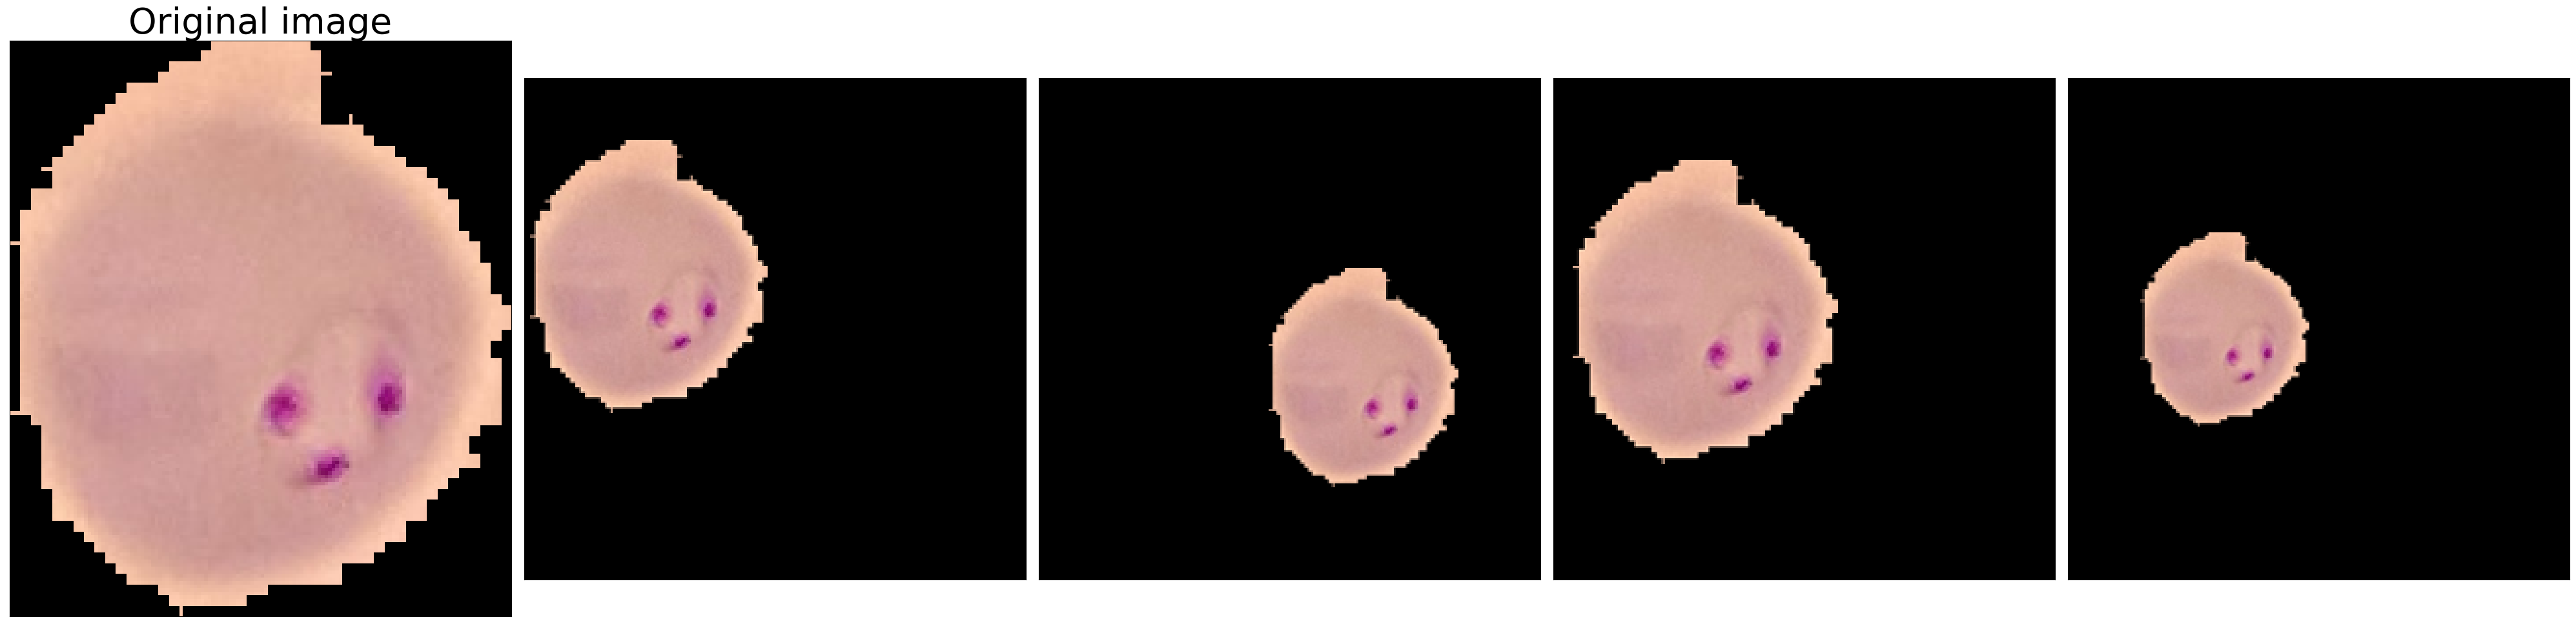

In [10]:
data_path = r"C:\Users\salom\OneDrive - mail.tau.ac.il\Desktop\deep learnning\exercice_4\cell_images"
orig_img = Image.open(os.path.join(data_path, "Parasitized/C33P1thinF_IMG_20150619_114756a_cell_179.png"))

rand_localized = [StretchLocAndRemember()(orig_img) for _ in range(4)]
plot(rand_localized)
print(rand_localized)

#### Loading Data Functions

In [11]:
def get_transforms():
    """
        Returns the transforms which will be applied to the data and the target.
        slar is a StretcLochAndRemember transform we have implemented in order to stretch an image and
        save its location. The saved location is used as the bounding box ground truth we are learning.
        That's why its object is common in both the images and target transformations.
    """
    slar = StretchLocAndRemember()

    common_transforms = transforms.Compose([
                    transforms.Resize([140, 140]),
                    slar,
                    transforms.ToTensor(),
                ])

    target_transforms = transforms.Compose([
                    slar,
                ])

    return common_transforms, target_transforms

def load_data(batch_size):
    common_transforms, target_transforms = get_transforms()
    train_set = ImageFolder(root=data_path, transform=common_transforms, target_transform=target_transforms)
    val_set_size = int(0.2 * len(train_set))
    trainset, valset = random_split(train_set, [len(train_set) - val_set_size, val_set_size])

    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader

##### Exploring one batch

In [12]:
train_loader, val_loader = load_data(batch_size=3)
data, target = next(iter(val_loader), [0])
print("bbox [x,y,w,h] are", target[0], "\nlabels are", target[1])

bbox [x,y,w,h] are tensor([[ 34., 111.,  85.,  85.],
        [ 31.,  83., 114., 114.],
        [  0., 102., 129., 129.]]) 
labels are tensor([0, 1, 1])


#### Model Definition

In [13]:
class CellNet(nn.Module):
    def __init__(self):
        super(CellNet, self).__init__()
        # kernel
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.conv4 = nn.Conv2d(64, 64, 3, stride=2)

        # Classifier HEAD
        self.fc1 = nn.Linear(576, 512)
        # what sohuld be second layer DIMs?
        self.fc2 = nn.Linear(512,2)#uninfected or parazited

        # Localization HEAD
        self.fc1_loc = nn.Linear(576,64)#
        # what sohuld be second layer DIMs?
        self.fc2_loc = nn.Linear(64,4)#x,y,w,h

    def forward(self, x):
        """
            Returns the predictions for the label and the location (in that order).
        """
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))

        # If the size of the max pool is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)), 4)

        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        loc = F.relu(self.fc1_loc(x))
        loc = self.fc2_loc(loc)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        #return both outputs
        return x,loc

#### Train Model

In [14]:
writer = SummaryWriter()

In [15]:
def train(model, optimizer, epoch, train_loader, log_interval):
    # state that you are training the model
    model.train()
    correct =0
    # define loss function
    # which loss should we use for the classifier and which for the localization?
    # here's a list for off the shelf pytorch loss
    # https://pytorch.org/docs/stable/nn.html#loss-functions
    classifier_loss = nn.CrossEntropyLoss()
    localization_loss = nn.MSELoss()

    # iterate over batches of data
    for batch_idx, (data, target) in enumerate(train_loader):
        location, label = target
        data, location, label = data.to(device), location.to(device), label.to(device)

        # clear the gradients, since PyTorch accumulates them
        optimizer.zero_grad()

        # forward propagation
        prediction, bbox = model(data)

        f_pred = torch.argmax(prediction.data, axis=1)

        loss = (1 - losses_ratio) * classifier_loss(prediction,label) + losses_ratio * localization_loss(bbox,location)

        # backward propagation
        loss.backward()

        # update the parameters (weight,bias)
        optimizer.step()

        # print log
        if batch_idx % log_interval == 0:
            print(f'Train set, Epoch {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
                  f' ({100. * batch_idx / len(train_loader):.0f}%)]\t'
                  f'Loss: {loss.data:.6f}')

            ###### Write events to Tensorboard here ######
            correct += torch.eq(f_pred, label).sum()
            writer.add_scalar('loss',loss.data, str(epoch) + '_' + str(batch_idx))
            writer.add_scalar('Accuracy',correct/len(val_loader.dataset), str(epoch) + '_' + str(batch_idx))

def eval(model, epoch, val_loader):
    # state that you are testing the model; this prevents layers e.g. Dropout to take effect
    model.eval()

    # init prediction accumulators
    correct, ious = 0, 0

    with torch.no_grad():
        for data, target in val_loader:
            location, label = target
            data, location, label = data.to(device), location.to(device), label.to(device)

            # forward propagation
            prediction, bbox = model(data)

            # get the index of the max log-probability (the predicted output label)
            pred = torch.argmax(prediction.data, axis=1)

            # if correct, increment correct prediction accumulator
            correct += torch.eq(pred, label).sum()

            for i in range(len(bbox)):
                ious += get_iou(location.data[i], bbox.data[i])

        ious /= 0.01 * len(val_loader.dataset)
        print(f'\nValidation set, Epoch {epoch}, Accuracy: {correct}/{len(val_loader.dataset)}'
              f' ({100. * correct / len(val_loader.dataset):.0f}%), '
              f'IOUS {ious}\n')

Start training

In [ ]:
# parameters definition
lr = 0.001
losses_ratio = 0.00006
epochs = 5
log_interval = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Working on device: {device}')

# initiate a mdoel
model = CellNet().to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)

# load data
batch_size = 128
train_loader, val_loader = load_data(batch_size)

# train model
for epoch in range(1, epochs + 1):
    train(model, optimizer, epoch, train_loader, log_interval)
    eval(model, epoch, val_loader)

print('Done training!')

Working on device: cpu
Train set, Epoch 1 [0/22047 (0%)]	Loss: 1.295657
Train set, Epoch 1 [6400/22047 (29%)]	Loss: 0.830693
Train set, Epoch 1 [12800/22047 (58%)]	Loss: 0.750050
Train set, Epoch 1 [19200/22047 (87%)]	Loss: 0.739409

Validation set, Epoch 1, Accuracy: 2803/5511 (51%), IOUS 58.97522735595703

Train set, Epoch 2 [0/22047 (0%)]	Loss: 0.722320
Train set, Epoch 2 [6400/22047 (29%)]	Loss: 0.709341
Train set, Epoch 2 [12800/22047 (58%)]	Loss: 0.708459
Train set, Epoch 2 [19200/22047 (87%)]	Loss: 0.705039

Validation set, Epoch 2, Accuracy: 2834/5511 (51%), IOUS 66.42585754394531

Train set, Epoch 3 [0/22047 (0%)]	Loss: 0.704117
Train set, Epoch 3 [6400/22047 (29%)]	Loss: 0.714995
Train set, Epoch 3 [12800/22047 (58%)]	Loss: 0.695875
Train set, Epoch 3 [19200/22047 (87%)]	Loss: 0.702621

Validation set, Epoch 3, Accuracy: 2949/5511 (54%), IOUS 70.04649353027344

Train set, Epoch 4 [0/22047 (0%)]	Loss: 0.695220
Train set, Epoch 4 [6400/22047 (29%)]	Loss: 0.708347
Train set, Epo

In [17]:
### Add Saving Trained Model ###
save_path = 'tained_locator.pt'
torch.save(model.state_dict(), save_path)

In [18]:
# load saved model
new_model = CellNet()
model.load_state_dict(torch.load(save_path))

# make model ready to inference
model.eval()

CellNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=576, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (fc1_loc): Linear(in_features=576, out_features=64, bias=True)
  (fc2_loc): Linear(in_features=64, out_features=4, bias=True)
)

#### Evaluate Predicted Bounding Box

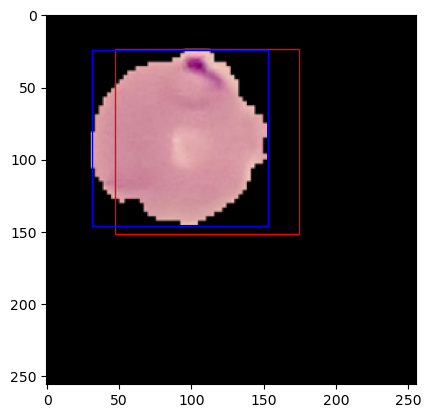

In [19]:
""" Explore one predicted bounding box """
data, (location, label) = next(iter(train_loader), [0])
data, location, label = data.to(device), location.to(device), label.to(device)
_, bbox = model(data)
bbox_plot(data[0], bbox[0], location[0])

#### Inference

In [20]:
### Add Inference Function ###
def test(test_loader,model):
    # make sure you load the saved trained model!

    # init prediction accumulators
    correct, ious = 0, 0

    with torch.no_grad():
        for data, target in test_loader:
            location, label = target
            data, location, label = data.to(device), location.to(device), label.to(device)

            # forward propagation
            prediction, bbox = model(data)

            # get the index of the max log-probability (the predicted output label)
            pred = torch.argmax(prediction.data, axis=1)

            # if correct, increment correct prediction accumulator
            correct += torch.eq(pred, label).sum()

            for i in range(len(bbox)):
                ious += get_iou(location.data[i], bbox.data[i])

        ious /= 0.01 * len(val_loader.dataset)
        print(f'\nValidation set, Epoch {epoch}, Accuracy: {correct}/{len(test_loader.dataset)}'
              f' ({100. * correct / len(test_loader.dataset):.0f}%), '
              f'IOUS {ious}\n')

In [21]:
### Initiate testing on validation set

test(val_loader,model)



Validation set, Epoch 5, Accuracy: 5054/5511 (92%), IOUS 65.84037780761719

